<br>
<br>

In [1]:
from IPython.display import Image
%matplotlib inline

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [1]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [2]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

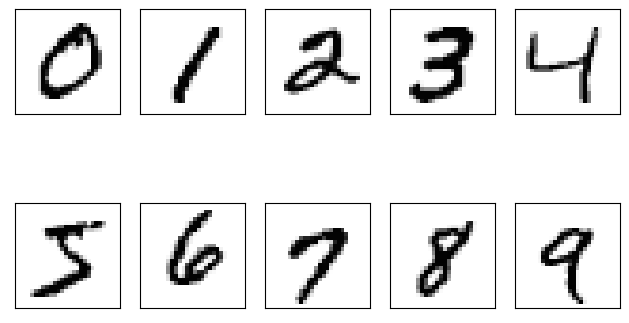

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

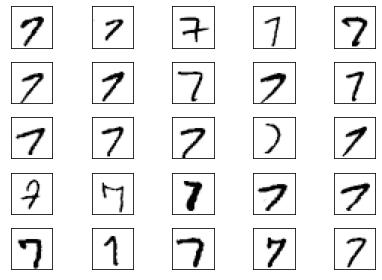

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

In [40]:
X.shape

torch.Size([100, 784])

Split into training, validation, and test set:

In [3]:
from sklearn.model_selection import train_test_split


# X_temp, X_test, y_temp, y_test = train_test_split(
#     X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)


# optional to free up some memory by deleting non-used arrays:
# del X_temp, y_temp, X, y

In [4]:
X_train.shape, X_valid.shape

((49000, 784), (21000, 784))

# one layer (original) model

In [5]:
import numpy as np

In [6]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)


## Coding the neural network training loop (original code)

In [7]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [8]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [9]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    epoch_train_AUC = []
    epoch_valid_AUC = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        
        epoch_loss.append(train_mse)
        
        
        # compute AUC
        _, probas_train = model.forward(X_train)
        _, probas_valid = model.forward(X_valid)
        
        train_macroAUC = macroAUC(int_to_onehot(y_train, num_labels=10),probas_train)
        valid_macroAUC = macroAUC(int_to_onehot(y_valid, num_labels=10),probas_valid)
        
        epoch_train_AUC.append(train_macroAUC)
        epoch_valid_AUC.append(valid_macroAUC)
        
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}% '
              f'| train macroAUC: {train_macroAUC:.2f} '
              f'| Valid macroAUC: {valid_macroAUC:.2f}')
                
                
    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_AUC, epoch_valid_AUC


In [10]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [11]:
from sklearn.metrics import roc_auc_score
from scipy.special import softmax

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

def macroAUC(targets, predicted_labels):
    return roc_auc_score(targets, predicted_labels,average='macro', multi_class='ovr')

_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
auc = macroAUC(y_valid, softmax(probas, axis=1))

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')
print(f'Initial validation MacroAUC: {auc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.2%
Initial validation MacroAUC: 52.0%


In [12]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_AUC, epoch_valid_AUC = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 74.70% | Valid Acc: 74.41% | train macroAUC: 0.95 | Valid macroAUC: 0.95
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 84.20% | Valid Acc: 84.24% | train macroAUC: 0.97 | Valid macroAUC: 0.97
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 87.56% | Valid Acc: 87.49% | train macroAUC: 0.98 | Valid macroAUC: 0.98
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 88.69% | Valid Acc: 88.68% | train macroAUC: 0.98 | Valid macroAUC: 0.98
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 89.84% | Valid Acc: 89.67% | train macroAUC: 0.98 | Valid macroAUC: 0.98
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.40% | Valid Acc: 90.25% | train macroAUC: 0.98 | Valid macroAUC: 0.98
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 90.84% | Valid Acc: 90.65% | train macroAUC: 0.99 | Valid macroAUC: 0.98
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.17% | Valid Acc: 91.03% | train macroAUC: 0.99 | Valid macroAUC: 0.99
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 91

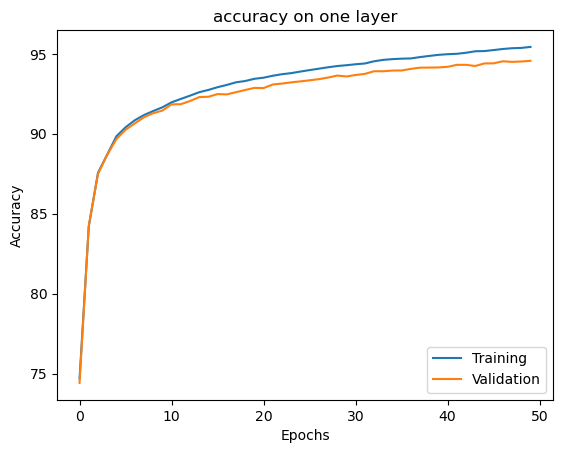

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('accuracy on one layer')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [14]:
test_mse, test_acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'valid accuracy: {test_acc*100:.2f}%')

valid accuracy: 94.56%


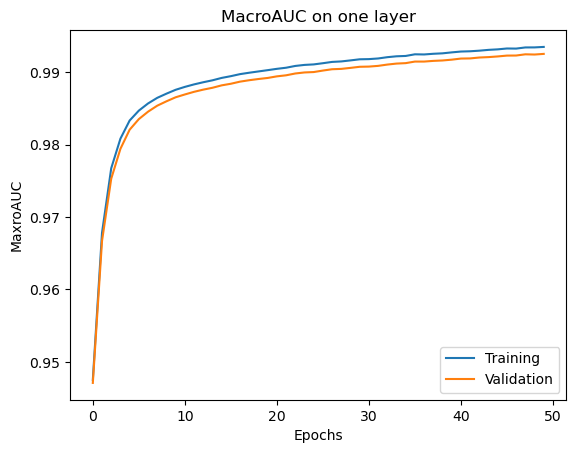

In [15]:
plt.plot(range(len(epoch_train_AUC)), epoch_train_AUC,
         label='Training')
plt.plot(range(len(epoch_valid_AUC)), epoch_valid_AUC,
         label='Validation')
plt.ylabel('MaxroAUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('MacroAUC on one layer')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [16]:
epoch_valid_AUC[-1]

0.9925564417641555

<br>
<br>

# Implementing a multi-layer perceptron

In [16]:
import numpy as np

In [17]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP_two_hidden:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden1
        rng = np.random.RandomState(random_seed)
        
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)
        
        # hidden2
        rng = np.random.RandomState(random_seed)
        
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h2 = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer1
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer2
        # input dim: [n_examples, n_hidden] dot [n_hidden, n_hidden].T
        # output dim: [n_examples, n_hidden]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)
        
        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h2
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHidden2Weights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h2 = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        
        # [n_examples, n_hidden]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative
        
        delta_hidden =  d_loss__a_h2 * d_a_h2__d_z_h2 # "delta (rule) placeholder"
        
        # [n_examples, n_features]
        d_z_h1__d_w_h1 = a_h1
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h2 = np.dot(delta_hidden.T, d_z_h1__d_w_h1)
        d_loss__d_b_h2 = np.sum(delta_hidden, axis=0)


        #################################        
        # Part 3: dLoss/dHidden1Weights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_hidden2__a_h = self.weight_h2 
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h1 = np.dot(delta_hidden, d_z_hidden2__a_h)
        
        # [n_examples, n_hidden]
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h__d_w_h)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1,)


In [18]:
model = NeuralNetMLP_two_hidden(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [19]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _,_, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [20]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_AUC = []
    epoch_valid_AUC = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
       

        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

        _,_, probas_train = model.forward(X_train)
        _,_, probas_valid = model.forward(X_valid)
        
        train_macroAUC = macroAUC(int_to_onehot(y_train, num_labels=10),probas_train)
        valid_macroAUC = macroAUC(int_to_onehot(y_valid, num_labels=10),probas_valid)
        
        
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_AUC.append(train_macroAUC)
        epoch_valid_AUC.append(valid_macroAUC)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}% '
              f'| train macroAUC: {train_macroAUC:.2f} '
              f'| Valid macroAUC: {valid_macroAUC:.2f}')

    return epoch_loss, epoch_train_AUC, epoch_valid_AUC


In [21]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 29.52% | Valid Acc: 29.37% | train macroAUC: 0.81 | Valid macroAUC: 0.81
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 32.91% | Valid Acc: 32.62% | train macroAUC: 0.87 | Valid macroAUC: 0.87
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 40.87% | Valid Acc: 40.57% | train macroAUC: 0.88 | Valid macroAUC: 0.88
Epoch: 004/050 | Train MSE: 0.06 | Train Acc: 55.77% | Valid Acc: 55.80% | train macroAUC: 0.90 | Valid macroAUC: 0.90
Epoch: 005/050 | Train MSE: 0.05 | Train Acc: 64.51% | Valid Acc: 64.54% | train macroAUC: 0.92 | Valid macroAUC: 0.92
Epoch: 006/050 | Train MSE: 0.04 | Train Acc: 69.44% | Valid Acc: 69.42% | train macroAUC: 0.93 | Valid macroAUC: 0.93
Epoch: 007/050 | Train MSE: 0.04 | Train Acc: 76.06% | Valid Acc: 75.70% | train macroAUC: 0.94 | Valid macroAUC: 0.94
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 81.51% | Valid Acc: 81.60% | train macroAUC: 0.96 | Valid macroAUC: 0.96
Epoch: 009/050 | Train MSE: 0.03 | Train Acc: 85

## Evaluating the neural network performance

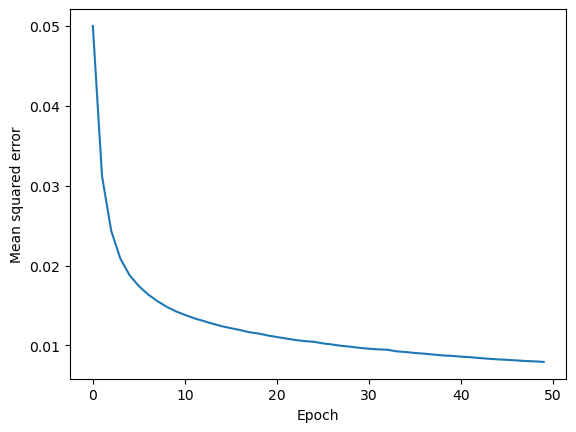

In [15]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

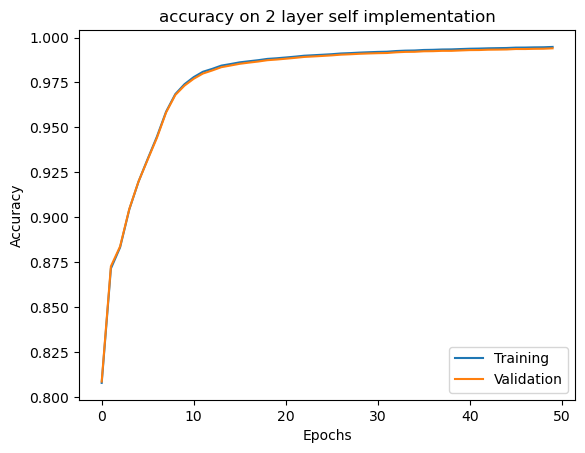

In [22]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('accuracy on 2 layer self implementation')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [23]:
test_mse, test_acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.94%


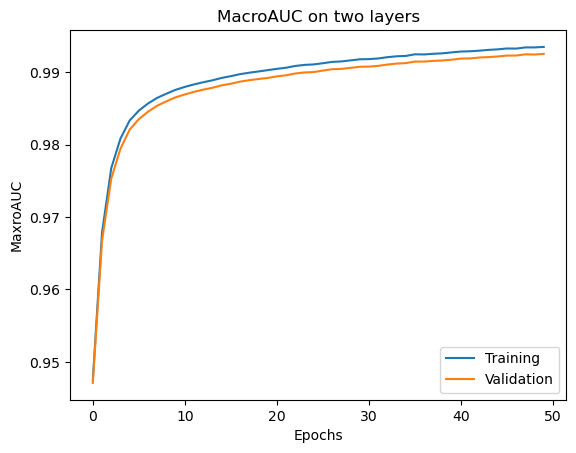

In [24]:
plt.plot(range(len(epoch_train_AUC)), epoch_train_AUC,
         label='Training')
plt.plot(range(len(epoch_valid_AUC)), epoch_valid_AUC,
         label='Validation')
plt.ylabel('MaxroAUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('MacroAUC on two layers')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [25]:
epoch_valid_AUC[-1]

0.9925564417641555

# simple linear model by pytorch (2 linear layers)

In [26]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [27]:
class Simple_torch_model(torch.nn.Module):

    def __init__(self):
        super(Simple_torch_model, self).__init__()

        self.linear1 = torch.nn.Linear(784, 50)
        self.activation = torch.nn.Sigmoid()
        self.linear2 = torch.nn.Linear(50, 10)
        

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x

###  wrap X,y as dataset class

In [28]:
class My_Mnist(Dataset):
    def __init__(self, X, y):
        self.featues = X
        self.labels = y
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.featues[idx], self.labels[idx]

In [29]:
def int_to_onehot_tensor(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y.numpy()):
        ary[i, int(val)] = 1

    return torch.Tensor(ary)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tinymodel = Simple_torch_model()
tinymodel.to(device)

My_Mnist_train = My_Mnist(torch.Tensor(X_train), torch.Tensor(y_train))

train_dataloader = DataLoader(My_Mnist_train, batch_size=100, shuffle=True)

epoch_train_acc = []
epoch_valid_acc = []
epoch_train_AUC = []
epoch_valid_AUC = []

n_epochs = 50
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(tinymodel.parameters(), lr=0.1)
train_loss, train_acc = 0, 0
for epoch in range(n_epochs):
    tinymodel.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = tinymodel(X)
        loss = loss_fn(y_pred, int_to_onehot_tensor(y, num_labels=10))
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    valid_loss, valid_acc = 0, 0
    tinymodel.eval()

    with torch.inference_mode():
        X_valid = torch.Tensor(X_valid).to(device)
        
        valid_pred = tinymodel(X_valid)


        valid_loss = loss_fn(valid_pred, torch.Tensor(int_to_onehot(y_valid, num_labels=10)).to(device))


        valid_loss = valid_loss / len(X_valid)


        y_pred_class = torch.argmax(torch.softmax(valid_pred, dim=1), dim=1)
        valid_acc += (y_pred_class == torch.Tensor(y_valid)).sum().item()/len(y_valid)

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        
        
        train_macroAUC = macroAUC(int_to_onehot(y_train, num_labels=10),tinymodel(torch.Tensor(X_train)))
        valid_macroAUC = macroAUC(int_to_onehot(y_valid, num_labels=10),valid_pred)
        
        

        epoch_train_AUC.append(train_macroAUC)
        epoch_valid_AUC.append(valid_macroAUC)

        print(f'Epoch: {epoch}/{num_epochs:03d} '
              f'| Train MSE: {train_loss:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}% '
              f'| train macroAUC: {train_macroAUC:.2f} '
              f'| Valid macroAUC: {valid_macroAUC:.2f}')
           


Epoch: 0/050 | Train MSE: 0.10 | Train Acc: 0.19% | Valid Acc: 0.29% | train macroAUC: 0.82 | Valid macroAUC: 0.82
Epoch: 1/050 | Train MSE: 0.09 | Train Acc: 0.32% | Valid Acc: 0.33% | train macroAUC: 0.88 | Valid macroAUC: 0.88
Epoch: 2/050 | Train MSE: 0.09 | Train Acc: 0.35% | Valid Acc: 0.38% | train macroAUC: 0.91 | Valid macroAUC: 0.91
Epoch: 3/050 | Train MSE: 0.08 | Train Acc: 0.41% | Valid Acc: 0.42% | train macroAUC: 0.93 | Valid macroAUC: 0.92
Epoch: 4/050 | Train MSE: 0.08 | Train Acc: 0.46% | Valid Acc: 0.50% | train macroAUC: 0.93 | Valid macroAUC: 0.93
Epoch: 5/050 | Train MSE: 0.07 | Train Acc: 0.52% | Valid Acc: 0.55% | train macroAUC: 0.94 | Valid macroAUC: 0.94
Epoch: 6/050 | Train MSE: 0.07 | Train Acc: 0.58% | Valid Acc: 0.60% | train macroAUC: 0.94 | Valid macroAUC: 0.94
Epoch: 7/050 | Train MSE: 0.06 | Train Acc: 0.63% | Valid Acc: 0.66% | train macroAUC: 0.95 | Valid macroAUC: 0.95
Epoch: 8/050 | Train MSE: 0.06 | Train Acc: 0.69% | Valid Acc: 0.70% | train mac

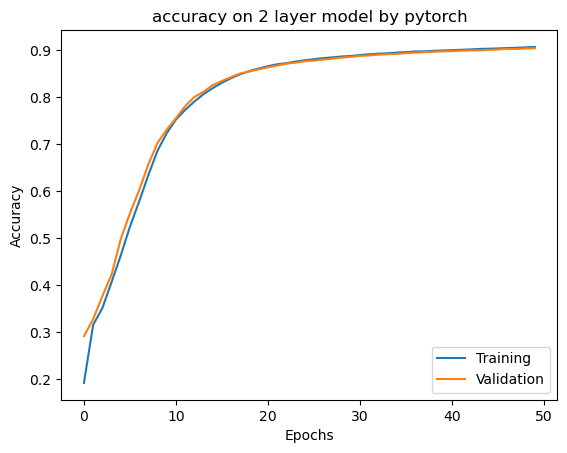

In [31]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('accuracy on 2 layer model by pytorch')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [32]:
print(f'Test accuracy: {valid_acc*100:.2f}%')

Test accuracy: 90.33%


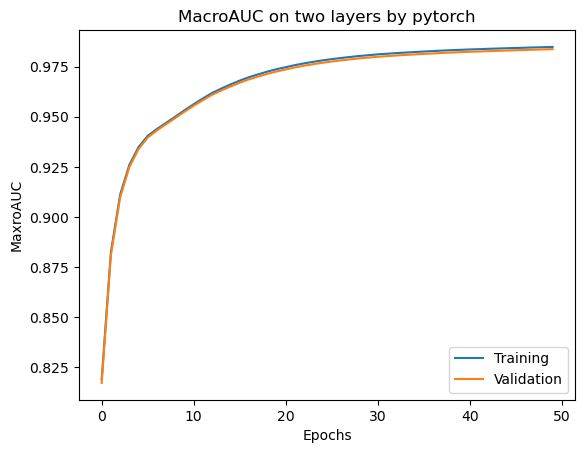

In [33]:
plt.plot(range(len(epoch_train_AUC)), epoch_train_AUC,
         label='Training')
plt.plot(range(len(epoch_valid_AUC)), epoch_valid_AUC,
         label='Validation')
plt.ylabel('MaxroAUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('MacroAUC on two layers by pytorch')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [34]:
epoch_valid_AUC[-1]

0.9837762048451026